In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import tensorflow as tf
import tensorflow_hub as hub
import os

**GETTING DATA READY**

In [2]:
test_csv=pd.DataFrame(columns=['id','classify'])
train_csv=pd.DataFrame(columns=['id','classify'])

In [3]:
path={'buldings':"../input/intel-image-classification/seg_train/seg_train/buildings/",
'forest':"../input/intel-image-classification/seg_train/seg_train/forest/",
'glacier':"../input/intel-image-classification/seg_train/seg_train/glacier/",
'mountain':"../input/intel-image-classification/seg_train/seg_train/mountain/",
'sea':"../input/intel-image-classification/seg_train/seg_train/sea/",
'street':"../input/intel-image-classification/seg_train/seg_train/street/" }

train_file_path=[]
train_csv_id=[]
train_csv_classify=[]
for i in path.keys():
    for id in os.listdir(path[i]):
        train_csv_id.append(id)
        train_csv_classify.append(i)
        train_file_path.append(path[i]+id)
    print(len(train_file_path))
train_csv['id']=train_csv_id
train_csv['classify']=train_csv_classify



2191
4462
6866
9378
11652
14034


In [4]:
path={'buldings':"../input/intel-image-classification/seg_test/seg_test/buildings/",
'forest':"../input/intel-image-classification/seg_test/seg_test/forest/",
'glacier':"../input/intel-image-classification/seg_test/seg_test/glacier/",
'mountain':"../input/intel-image-classification/seg_test/seg_test/mountain/",
'sea':"../input/intel-image-classification/seg_test/seg_test/sea/",
'street':"../input/intel-image-classification/seg_test/seg_test/street/" }

test_file_path=[]
test_csv_id=[]
test_csv_classify=[]
for i in path.keys():
    for id in os.listdir(path[i]):
        test_csv_id.append(id)
        test_csv_classify.append(i)
        test_file_path.append(path[i]+id)
    print(len(test_file_path))
test_csv['id']=test_csv_id
test_csv['classify']=test_csv_classify



437
911
1464
1989
2499
3000


In [5]:
train_csv['id'].head()

0     2193.jpg
1    11378.jpg
2    10730.jpg
3    17338.jpg
4    16730.jpg
Name: id, dtype: object

<AxesSubplot:>

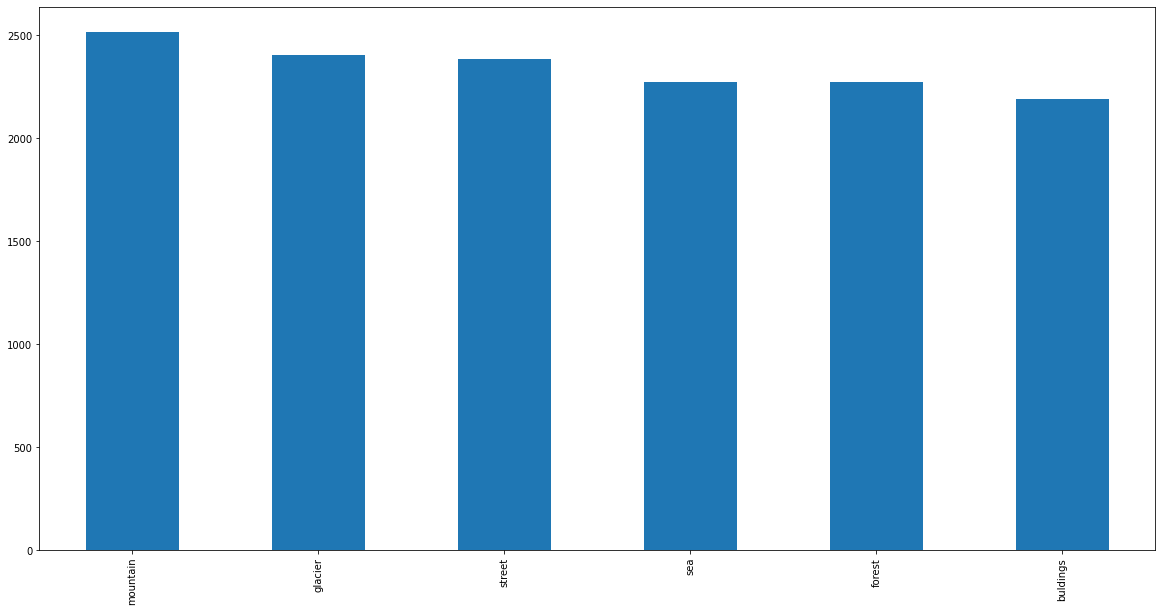

In [6]:
train_csv['classify'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

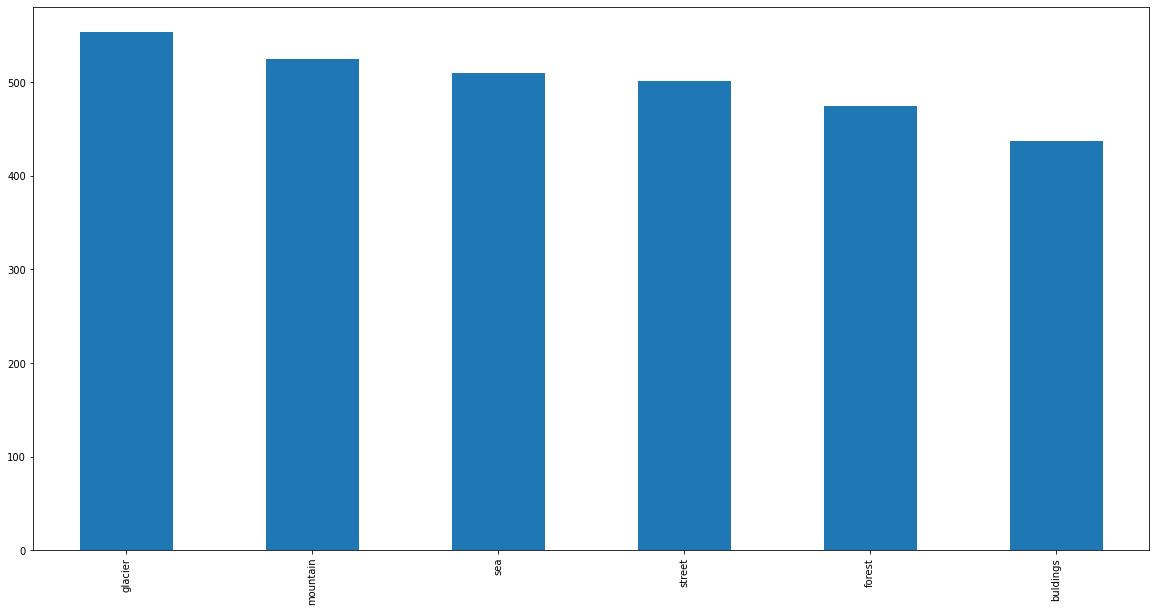

In [7]:
test_csv['classify'].value_counts().plot.bar(figsize=(20,10))

**CONVERTING LABELS INTO BOOLEAN VALUES**

In [8]:
labels_train=np.array(train_csv['classify'])
labels_test=np.array(test_csv['classify'])
unique_breeds=np.unique(labels_train)
boolean_values_train=[label==unique_breeds for label in labels_train]
boolean_values_test=[label==unique_breeds for label in labels_test]

In [9]:
unique_breeds

array(['buldings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

In [10]:
def tensor(fp):
  image=tf.io.read_file(fp) #or we can use plt.imread(fp)
  image=tf.image.decode_jpeg(image,3) #or we can use image=tf.constant(image)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,(224,224))
  return image

In [11]:
def get_tuple(image_path,label):
  image=tensor(image_path)
  return image,label

**DIVIDING DATA INTO BACTHES OF SIZE 32**

In [12]:
BATCH_SIZE=32

def data_batches(X,y=None,batch_size=BATCH_SIZE,test_data=False,prediction_data=False):
  if prediction_data:
    print("pred_data")
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X)) #we use this unbatch the data
    data=data.map(tensor).batch(BATCH_SIZE)    # we use this to map and bacth data of batch_size=2
    return data
  elif test_data:
    print("test_data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                            tf.constant(y)))
    data=data.map(get_tuple).batch(BATCH_SIZE)
    return data
  else:
    print("train_data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                            tf.constant(y)))
    data=data.shuffle(buffer_size=len(X))
    data=data.map(get_tuple).batch(BATCH_SIZE)
    return data
    

In [13]:
X=train_file_path
y=boolean_values_train
train_data=data_batches(X,y)

train_data


2022-10-04 08:46:32.565254: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
X=test_file_path
y=boolean_values_test
test_data=data_batches(X,y,test_data=True)

test_data


In [15]:
train_images,train_labels=next(train_data.as_numpy_iterator())
train_images,train_labels

2022-10-04 08:46:32.871238: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(array([[[[0.27450982, 0.43529415, 0.60784316],
          [0.26857495, 0.41551125, 0.59003854],
          [0.26889008, 0.3953957 , 0.57254905],
          ...,
          [0.48266867, 0.42417797, 0.44513422],
          [0.4572996 , 0.41409245, 0.46881968],
          [0.40784317, 0.37254903, 0.44705886]],
 
         [[0.26857495, 0.43727243, 0.6058649 ],
          [0.26064414, 0.41649157, 0.5850663 ],
          [0.26347628, 0.39952892, 0.5677358 ],
          ...,
          [0.42970476, 0.36769015, 0.3906247 ],
          [0.4399993 , 0.38987696, 0.44462183],
          [0.4454307 , 0.4022234 , 0.47475493]],
 
         [[0.25660014, 0.4398985 , 0.6039216 ],
          [0.2515308 , 0.42261493, 0.583282  ],
          [0.25931352, 0.41053253, 0.56546754],
          ...,
          [0.39604923, 0.33072245, 0.355838  ],
          [0.43301803, 0.37372836, 0.4288289 ],
          [0.4796219 , 0.42454484, 0.49581584]],
 
         ...,
 
         [[0.1457808 , 0.10264355, 0.03205531],
          [0.12446

In [16]:
test_images,test_labels=next(test_data.as_numpy_iterator())
test_images,test_labels

(array([[[[0.04705883, 0.10588236, 0.36078432],
          [0.04705883, 0.10588236, 0.36078432],
          [0.0477416 , 0.10656513, 0.3614671 ],
          ...,
          [0.05166315, 0.11048669, 0.36538863],
          [0.0509804 , 0.10980393, 0.3647059 ],
          [0.0509804 , 0.10980393, 0.3647059 ]],
 
         [[0.04705883, 0.10588236, 0.36078432],
          [0.04705883, 0.10588236, 0.36078432],
          [0.0477416 , 0.10656513, 0.3614671 ],
          ...,
          [0.05493088, 0.11375441, 0.36865637],
          [0.05493698, 0.11376051, 0.36866248],
          [0.05493698, 0.11376051, 0.36866248]],
 
         [[0.04705883, 0.10588236, 0.36078432],
          [0.04740326, 0.10622679, 0.36112875],
          [0.0483055 , 0.10712903, 0.36203098],
          ...,
          [0.05757688, 0.11640041, 0.37154013],
          [0.0584791 , 0.11730264, 0.3722046 ],
          [0.05882353, 0.11764707, 0.37254903]],
 
         ...,
 
         [[0.4566859 , 0.34926304, 0.28224644],
          [0.59135

**VISUALIZE**

In [17]:
import matplotlib.pyplot as plt
def visualize(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

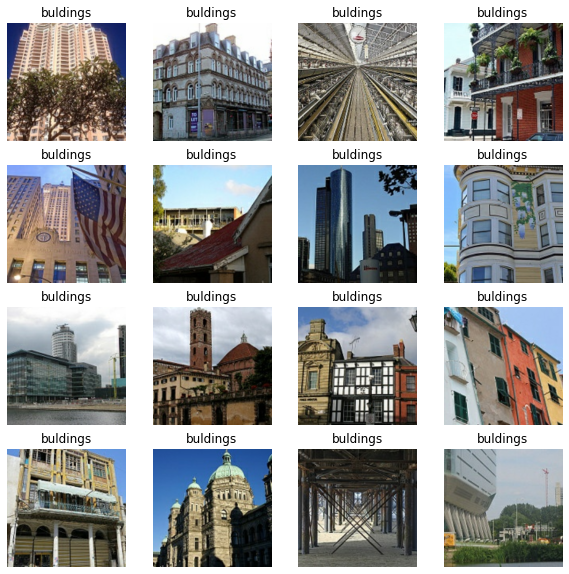

In [18]:
visualize(test_images,test_labels)

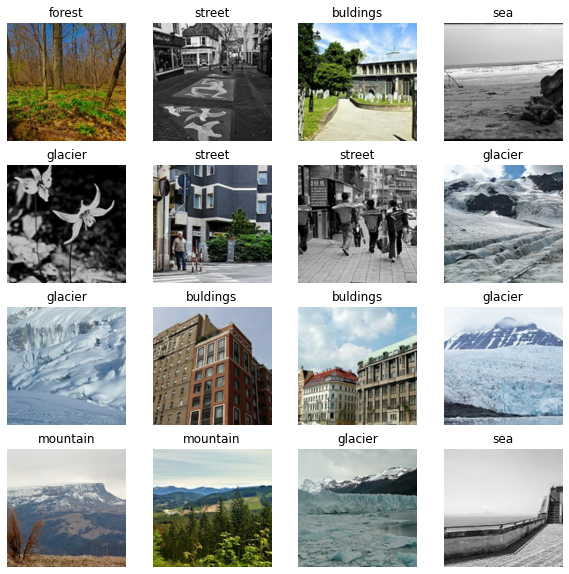

In [19]:
visualize(train_images,train_labels)

**CREATE MODEL**

In [20]:
INPUT_SIZE=[None,224,224,3]
OUTPUT_SIZE=len(unique_breeds)
model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
def create_model(INPUT_SIZE=[None,224,224,3],OUTPUT_SIZE=len(unique_breeds),model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"):

  #setting up the layers
  model=tf.keras.Sequential([
      hub.KerasLayer(model_url),
      tf.keras.layers.Dense(units=OUTPUT_SIZE,
                            activation='softmax')])
  
  #compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  #bulid the model
  model.build(INPUT_SIZE)

  return model

In [21]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 6)                 6012      
Total params: 5,438,725
Trainable params: 6,012
Non-trainable params: 5,432,713
_________________________________________________________________


**CALL BACKS**

In [22]:
import datetime
 
# we tensorboard to check and save the progress

def call_Teansorboard():
  #create a log folder in mydrive to store logs
  log_dir=os.path.join("./logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [23]:
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=3)

**MODEL TRAIN**

In [24]:
def train_model():
  #create a model
  model=create_model()

  #tensorboard
  tensorboard=call_Teansorboard()

  #fit model
  model.fit(x=train_data,
            epochs=10,
            callbacks=[tensorboard,earlystopping])
  return model

In [25]:
model=train_model()

2022-10-04 08:46:42.462028: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-04 08:46:42.462335: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-04 08:46:42.463950: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
  1/439 [..............................] - ETA: 40:09 - loss: 2.3104 - accuracy: 0.4375

2022-10-04 08:46:48.413102: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-04 08:46:48.413272: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/439 [..............................] - ETA: 6:17 - loss: 2.5844 - accuracy: 0.3906 

2022-10-04 08:46:48.896708: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-04 08:46:48.911433: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-04 08:46:48.932411: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20221004-084642/train/plugins/profile/2022_10_04_08_46_48

2022-10-04 08:46:48.937707: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/20221004-084642/train/plugins/profile/2022_10_04_08_46_48/2428b5888718.trace.json.gz
2022-10-04 08:46:48.970018: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20221004-084642/train/plugins/profile/2022_10_04_08_46_48

2022-10-04 08:46:48.973343: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/20221004-084642/train/plugins/profile/2022_10_04_08

439/439 [==============================] - 207s 460ms/step - loss: 0.3179 - accuracy: 0.8828
Epoch 2/10
439/439 [==============================] - 199s 453ms/step - loss: 0.2158 - accuracy: 0.9208
Epoch 3/10
439/439 [==============================] - 202s 461ms/step - loss: 0.1952 - accuracy: 0.9285
Epoch 4/10
439/439 [==============================] - 201s 457ms/step - loss: 0.1872 - accuracy: 0.9311
Epoch 5/10
439/439 [==============================] - 201s 457ms/step - loss: 0.1771 - accuracy: 0.9359
Epoch 6/10
439/439 [==============================] - 213s 485ms/step - loss: 0.1718 - accuracy: 0.9367
Epoch 7/10
439/439 [==============================] - 205s 466ms/step - loss: 0.1664 - accuracy: 0.9373
Epoch 8/10
439/439 [==============================] - 206s 469ms/step - loss: 0.1605 - accuracy: 0.9407
Epoch 9/10
439/439 [==============================] - 204s 463ms/step - loss: 0.1578 - accuracy: 0.9407
Epoch 10/10
439/439 [==============================] - 210s 477ms/step - lo

**PREDICTIONS**

In [26]:
predictions=model.predict(test_data,verbose=1)
len(predictions)# ---> these are probability of unique breeds

94/94 [==============================] - 46s 483ms/step


3000

In [27]:
def get_labels_predicted(prediction):
  li=[]
  for i in range(len(prediction)):
    li.append(unique_breeds[prediction[i].argmax()])
  return li

def get_label_predicted(predict):
  return unique_breeds[predict.argmax()]



def unbatch(data):
  data_images=[]
  data_labels=[]
  for images,labels in data.unbatch().as_numpy_iterator():
    data_images.append(images)
    data_labels.append(labels)
  return data_images,get_labels_predicted(data_labels)

In [28]:
test_images,test_labels=unbatch(test_data)
len(test_images)

3000

**PLOTTING THE PREDICTIONS**

In [29]:
def plot(predic,val_labels,val_images,n=1):
  plt.imshow(val_images[n])
  plt.xticks([])
  plt.yticks([])

  if get_label_predicted(predic[n])==val_labels[n]:
    color='green'
  else:
    color='red'
  
  plt.axis('off')
  plt.title("{} {:2.0f}% {}".format(get_label_predicted(predic[n]),max(predic[n])*100,val_labels[n]),color=color)


def predictions_correct_count(valid_labels,predictions):
  count=0
  for i in range(len(predictions)):
    if valid_labels[i]==get_label_predicted(predictions[i]):
      count+=1
  return count



def top_10_possibilities_plot(predic,val_labels,n=1):

  top_10_possibilities_indexes=predic[n].argsort()[-10:][::-1]

  top_10_possibilities_values=predic[n][top_10_possibilities_indexes]

  top_10_possibilities_labels=unique_breeds[top_10_possibilities_indexes]

  top_plot=plt.bar(np.arange(len(top_10_possibilities_labels)),top_10_possibilities_values,color='grey')

  plt.xticks(np.arange(len(top_10_possibilities_labels)),top_10_possibilities_labels,rotation='vertical')

  if np.isin(val_labels[n],top_10_possibilities_labels):
    top_plot[np.argmax(top_10_possibilities_labels==val_labels[n])].set_color('green')
  else:
    pass
  

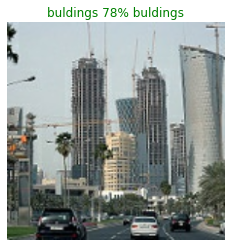

In [30]:
plot(predictions,test_labels,test_images,191)

In [31]:
predictions_correct_count(test_labels,predictions)

2743

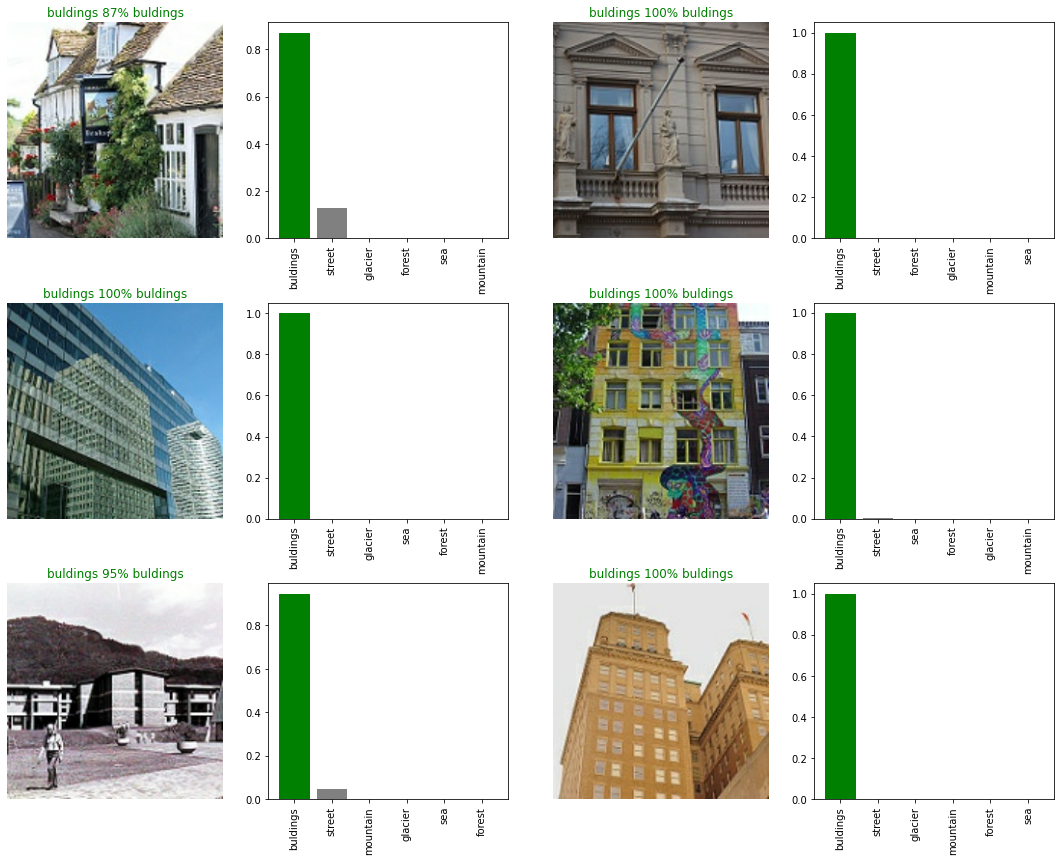

In [32]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(7.5*num_cols, 4*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot(predictions,
            test_labels,
            test_images,
            i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  top_10_possibilities_plot(predictions,
                 test_labels,
                 i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**SAVE THE MODEL**

In [33]:
def save_model(model, suffix=None):
  # Create a model directory pathname with current time
  modeldir = os.path.join("./models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [34]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [35]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: ./models/20221004-09271664875642-1000-images-mobilenetv2-Adam.h5...


'./models/20221004-09271664875642-1000-images-mobilenetv2-Adam.h5'

**PREDICTIONS ON PRED DATA**

In [36]:
pred_csv=pd.DataFrame(columns=['id','classify'])

In [37]:
path="../input/intel-image-classification/seg_pred/seg_pred/"

pred_file_path=[]
id=[]
for i in os.listdir(path):
    id.append(i)
    pred_file_path.append(path+i)
print(len(pred_file_path))
pred_csv['id']=id



7301


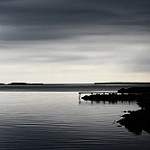

In [38]:
Image(pred_file_path[0])

In [39]:
pred_data=data_batches(pred_file_path,prediction_data=True)
len(pred_data)

pred_data


229

In [40]:
pred_predictions=model.predict(pred_data,verbose=1)

229/229 [==============================] - 118s 512ms/step


In [41]:
classify=[]
for i in pred_predictions:
    for j in range(6):
        if i[j]==max(i):
            classify.append(unique_breeds[j])

In [42]:
classify[:5]

['sea', 'street', 'mountain', 'buldings', 'mountain']

In [43]:
pred_csv['classify']=classify

In [44]:
pred_csv.head()   #----> final csv file for pred data

,id,classify
0,6234.jpg,sea
1,22288.jpg,street
2,20529.jpg,mountain
3,21440.jpg,buldings
4,5982.jpg,mountain
